# k-Means

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

In [2]:
original_img = plt.imread("original_image.jpg")

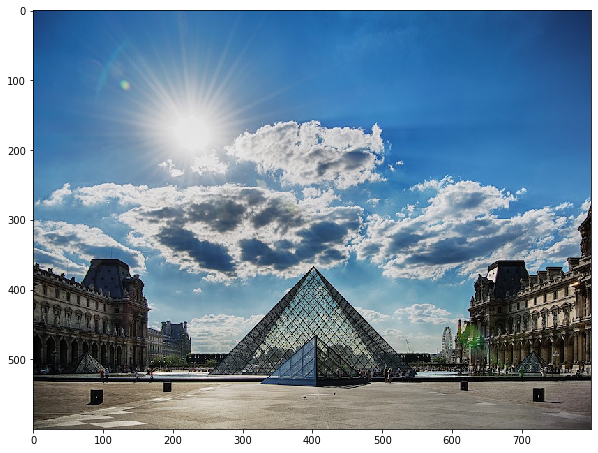

In [3]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(original_img)

In [4]:
X = original_img.reshape((original_img.shape[0]*original_img.shape[1], 3))

In [5]:
class Layer1():
    
    def __init__(self, model, input_dim, n_clusters):
        self.model = model
        self.input_dim = input_dim
        self.n_clusters = n_clusters
        self.build()
        
    def add_weight(self, shape):
        weight_init = tf.random.normal(shape=shape, mean=0.0, stddev=0.05, dtype="float32")
        return tf.Variable(initial_value=weight_init, trainable=True)
        
    def build(self):
        self.w = self.add_weight(shape=(self.n_clusters, self.input_dim))
        self.weights = [self.w]

    def __call__(self, inputs):        
        m = tf.shape(inputs)[0]
        u = tf.repeat(tf.expand_dims(tf.transpose(self.w), axis=0), repeats=m, axis=0)
        x = tf.repeat(tf.expand_dims(inputs, axis=2), repeats=self.n_clusters, axis=2)
        return tf.reduce_sum(tf.square(u-x), axis=1)
    
class Layer2():
    
    def __init__(self, model):
        self.model = model
        self.build()
            
    def build(self): 
        self.weights = []

    def __call__(self, inputs):
        return tf.reshape(tf.math.argmin(inputs, axis=1), shape=(-1,1))
    
class Layer3():
    
    def __init__(self, model):
        self.model = model
        self.build()
            
    def build(self): 
        self.weights = []

    def __call__(self, inputs):
        z = tf.math.argmin(inputs, axis=1)
        return tf.gather(self.model.weights[0], z, axis=0)

In [6]:
class LossFunction():
        
    def __init__(self, model):
        self.model = model
            
    def __call__(self, z):
        return tf.reduce_mean(tf.math.reduce_min(z, axis=1))

In [7]:
class Optimizer():

    def __init__(self, model, learning_rate, beta_1, beta_2, epsilon):
        self.model = model
        self.learning_rate = learning_rate
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon= epsilon
        self.stop_training = False
        self.build()
        
    def add_weight(self, shape):
        weight_init = tf.zeros(shape=shape, dtype="float32")
        return  tf.Variable(initial_value=weight_init, trainable=False)
    
    def build(self):
        self.weights = []
        for weight in self.model.weights:
            m = self.add_weight(shape=weight.shape)
            v = self.add_weight(shape=weight.shape)
            self.weights.append([m,v])
            
    def apply(self, grads, weights):
        for i in range(len(weights)):
            w = weights[i]
            grad_w = grads[i]
            m = self.weights[i][0]
            v = self.weights[i][1]
            self.weights[i][0].assign(self.beta_1*m + (1-self.beta_1)*grad_w)  
            self.weights[i][1].assign(self.beta_2*v + (1-self.beta_2)*grad_w*grad_w)
            m_ = (1/(1-self.beta_1))*self.weights[i][0]
            v_ = (1/(1-self.beta_2))*self.weights[i][1]
            weights[i].assign(w - self.learning_rate*m_/(tf.math.sqrt(v_)+self.epsilon))
            
    def train_step(self, X):
        with tf.GradientTape() as tape:
            H = self.model(X)
            loss = self.model.loss(H)
        grads = tape.gradient(loss, self.model.weights)
        self.apply(grads, self.model.weights)
        H = self.model(X)
        loss = self.model.loss(H)
        logs = {'loss': loss}
        return logs

In [8]:
class Callback1():

    def __init__(self, model, verbose):
        self.model = model
        self.verbose = verbose
    
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = tf.timestamp()
        
    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            now = tf.timestamp()
            time = now - self.start_time
            tf.print('Epochs {}/{} - Loss: {}'.format(epoch+1, self.model.epochs, logs['loss']))
            tf.print('----- {}s -----'.format(tf.round(1000*time)/1000))
            
class Callback2():

    def __init__(self, model):
        self.model = model
        self.history = {'loss':[]}
        
    def on_epoch_end(self, epoch, logs):
        self.history['loss'].append(logs['loss'].numpy())
        
    def on_train_end(self):
        self.model.history = self.history

class Callback3():
        
    def __init__(self, model, patience, error, reduce_factor, min_learning_rate):
        self.model = model
        self.patience = patience
        self.error = error
        self.reduce_factor = reduce_factor
        self.min_learning_rate = min_learning_rate
                        
    def on_epoch_end(self, epoch, logs):
        if epoch==0:
            self.loss = logs['loss']
            self.non_decreasing_epochs = 0
        else:
            if ((self.loss-logs['loss'])>self.error):
                self.loss = logs['loss']
                self.non_decreasing_epochs = 0
            else:
                self.non_decreasing_epochs = self.non_decreasing_epochs+1
        if (self.non_decreasing_epochs == self.patience):
            if (self.model.optimizer.learning_rate>self.min_learning_rate):
                self.model.optimizer.learning_rate = self.reduce_factor*self.model.optimizer.learning_rate
                self.non_decreasing_epochs = 0
        
class Callback4():
        
    def __init__(self, model, patience, error):
        self.model = model
        self.patience = patience
        self.error = error
        
    def on_epoch_end(self, epoch, logs):
        if epoch==0:
            self.loss = logs['loss']
            self.non_decreasing_epochs = 0
        else:
            if ((self.loss-logs['loss'])>self.error):
                self.loss = logs['loss']
                self.non_decreasing_epochs = 0
            else:
                self.non_decreasing_epochs = self.non_decreasing_epochs+1
        if (self.non_decreasing_epochs == self.patience):
            self.model.optimizer.stop_training = True

In [9]:
class KMeans():
    
    def __init__(self, input_dim, n_clusters):
        self.input_dim = input_dim
        self.n_clusters = n_clusters
        self.build()
     
    def build(self):
        self.h1 = Layer1(model=self, input_dim=self.input_dim, n_clusters=self.n_clusters)
        self.h2 = Layer2(model=self)
        self.h3 = Layer3(model=self)
        self.layers = [self.h1, self.h2, self.h3]
        self.weights = []
        for layer in self.layers:
            for weight in layer.weights:
                self.weights.append(weight)
        
    def __call__(self, inputs):        
        y = self.h1(inputs)
        return y 
        
    def train_setup(self, epochs, learning_rate, beta_1, beta_2, epsilon, verbose):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.beta_1 = beta_1 
        self.beta_2 = beta_2 
        self.epsilon = epsilon
        self.verbose = verbose
        self.loss = LossFunction(model=self)
        self.optimizer = Optimizer(model=self, learning_rate=self.learning_rate, beta_1=self.beta_1, beta_2=self.beta_2, epsilon=self.epsilon) 
        self.callbacks = [Callback1(model=self, verbose=self.verbose),
                          Callback2(model=self),
                          Callback3(model=self, patience=100, error=0.0001, reduce_factor=0.1, min_learning_rate=0.001),
                          Callback4(model=self, patience=200, error=0.0001)]
        
    def fit(self, X, epochs=5000, learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-07, verbose=True):
        self.train_setup(epochs, learning_rate, beta_1, beta_2, epsilon,verbose)
        if verbose:
            tf.print('Train on {} samples'.format(X.shape[0]))
        for epoch in range(epochs):
            self.callbacks[0].on_epoch_begin(epoch)
            logs = self.optimizer.train_step(tf.constant(X, dtype="float32"))
            for callback in self.callbacks:
                callback.on_epoch_end(epoch, logs)
            if self.optimizer.stop_training:
                break
        self.callbacks[1].on_train_end()
            
    def predict(self, inputs):
        return self(tf.constant(inputs, dtype="float32")).numpy()
    
    def clusters(self, inputs):
        return self.h2(self(tf.constant(inputs, dtype="float32"))).numpy()
        
    def centroids(self, inputs):
        return self.h3(self(tf.constant(inputs, dtype="float32"))).numpy()
        
    def evaluate(self, X):
        loss = self.loss(self(tf.constant(X, dtype="float32")))
        loss_numpy = loss.numpy()
        tf.print('Loss: {}'.format(loss_numpy))
        return [loss_numpy]

In [10]:
kmeans = KMeans(input_dim=X.shape[1], n_clusters=16)

kmeans.fit(X)

Train on 480000 samples
Epochs 1/5000 - Loss: 56154.1171875
----- 0.964s -----
Epochs 2/5000 - Loss: 56054.84375
----- 0.338s -----
Epochs 3/5000 - Loss: 55939.33203125
----- 0.296s -----
Epochs 4/5000 - Loss: 55812.53125
----- 0.301s -----
Epochs 5/5000 - Loss: 55677.65234375
----- 0.3s -----
Epochs 6/5000 - Loss: 55536.9765625
----- 0.293s -----
Epochs 7/5000 - Loss: 55392.1796875
----- 0.297s -----
Epochs 8/5000 - Loss: 55244.51171875
----- 0.299s -----
Epochs 9/5000 - Loss: 55094.609375
----- 0.297s -----
Epochs 10/5000 - Loss: 54942.34765625
----- 0.296s -----
Epochs 11/5000 - Loss: 54788.53125
----- 0.304s -----
Epochs 12/5000 - Loss: 54632.46484375
----- 0.298s -----
Epochs 13/5000 - Loss: 54474.59765625
----- 0.288s -----
Epochs 14/5000 - Loss: 54315.57421875
----- 0.296s -----
Epochs 15/5000 - Loss: 54155.98828125
----- 0.292s -----
Epochs 16/5000 - Loss: 53996.4140625
----- 0.289s -----
Epochs 17/5000 - Loss: 53837.27734375
----- 0.321s -----
Epochs 18/5000 - Loss: 53678.9492

----- 0.294s -----
Epochs 147/5000 - Loss: 40360.1796875
----- 0.305s -----
Epochs 148/5000 - Loss: 40259.125
----- 0.298s -----
Epochs 149/5000 - Loss: 40159.48046875
----- 0.292s -----
Epochs 150/5000 - Loss: 40061.21484375
----- 0.304s -----
Epochs 151/5000 - Loss: 39964.24609375
----- 0.315s -----
Epochs 152/5000 - Loss: 39868.546875
----- 0.306s -----
Epochs 153/5000 - Loss: 39774.07421875
----- 0.3s -----
Epochs 154/5000 - Loss: 39680.74609375
----- 0.297s -----
Epochs 155/5000 - Loss: 39588.51953125
----- 0.3s -----
Epochs 156/5000 - Loss: 39497.35546875
----- 0.323s -----
Epochs 157/5000 - Loss: 39407.1875
----- 0.302s -----
Epochs 158/5000 - Loss: 39318.0
----- 0.303s -----
Epochs 159/5000 - Loss: 39229.73046875
----- 0.299s -----
Epochs 160/5000 - Loss: 39142.3203125
----- 0.35s -----
Epochs 161/5000 - Loss: 39055.6875
----- 0.315s -----
Epochs 162/5000 - Loss: 38969.7265625
----- 0.303s -----
Epochs 163/5000 - Loss: 38884.34765625
----- 0.309s -----
Epochs 164/5000 - Loss: 3

----- 0.326s -----
Epochs 291/5000 - Loss: 28776.875
----- 0.298s -----
Epochs 292/5000 - Loss: 28726.783203125
----- 0.307s -----
Epochs 293/5000 - Loss: 28677.037109375
----- 0.306s -----
Epochs 294/5000 - Loss: 28627.638671875
----- 0.339s -----
Epochs 295/5000 - Loss: 28578.568359375
----- 0.338s -----
Epochs 296/5000 - Loss: 28529.833984375
----- 0.312s -----
Epochs 297/5000 - Loss: 28481.41796875
----- 0.318s -----
Epochs 298/5000 - Loss: 28433.33203125
----- 0.296s -----
Epochs 299/5000 - Loss: 28385.55859375
----- 0.292s -----
Epochs 300/5000 - Loss: 28338.08203125
----- 0.327s -----
Epochs 301/5000 - Loss: 28290.923828125
----- 0.308s -----
Epochs 302/5000 - Loss: 28244.056640625
----- 0.317s -----
Epochs 303/5000 - Loss: 28197.486328125
----- 0.308s -----
Epochs 304/5000 - Loss: 28151.20703125
----- 0.306s -----
Epochs 305/5000 - Loss: 28105.212890625
----- 0.305s -----
Epochs 306/5000 - Loss: 28059.5078125
----- 0.301s -----
Epochs 307/5000 - Loss: 28014.072265625
----- 0.31

----- 0.297s -----
Epochs 433/5000 - Loss: 23696.83984375
----- 0.307s -----
Epochs 434/5000 - Loss: 23669.98046875
----- 0.31s -----
Epochs 435/5000 - Loss: 23643.201171875
----- 0.297s -----
Epochs 436/5000 - Loss: 23616.51171875
----- 0.297s -----
Epochs 437/5000 - Loss: 23589.88671875
----- 0.303s -----
Epochs 438/5000 - Loss: 23563.35546875
----- 0.299s -----
Epochs 439/5000 - Loss: 23536.90234375
----- 0.301s -----
Epochs 440/5000 - Loss: 23510.521484375
----- 0.301s -----
Epochs 441/5000 - Loss: 23484.216796875
----- 0.298s -----
Epochs 442/5000 - Loss: 23457.986328125
----- 0.294s -----
Epochs 443/5000 - Loss: 23431.841796875
----- 0.3s -----
Epochs 444/5000 - Loss: 23405.76171875
----- 0.296s -----
Epochs 445/5000 - Loss: 23379.765625
----- 0.296s -----
Epochs 446/5000 - Loss: 23353.841796875
----- 0.3s -----
Epochs 447/5000 - Loss: 23327.9921875
----- 0.295s -----
Epochs 448/5000 - Loss: 23302.21484375
----- 0.296s -----
Epochs 449/5000 - Loss: 23276.51171875
----- 0.297s ---

Epochs 575/5000 - Loss: 20503.484375
----- 0.299s -----
Epochs 576/5000 - Loss: 20484.44921875
----- 0.302s -----
Epochs 577/5000 - Loss: 20465.455078125
----- 0.299s -----
Epochs 578/5000 - Loss: 20446.498046875
----- 0.298s -----
Epochs 579/5000 - Loss: 20427.578125
----- 0.297s -----
Epochs 580/5000 - Loss: 20408.6953125
----- 0.299s -----
Epochs 581/5000 - Loss: 20389.845703125
----- 0.295s -----
Epochs 582/5000 - Loss: 20371.0390625
----- 0.297s -----
Epochs 583/5000 - Loss: 20352.2734375
----- 0.298s -----
Epochs 584/5000 - Loss: 20333.53515625
----- 0.292s -----
Epochs 585/5000 - Loss: 20314.845703125
----- 0.299s -----
Epochs 586/5000 - Loss: 20296.185546875
----- 0.3s -----
Epochs 587/5000 - Loss: 20277.5625
----- 0.288s -----
Epochs 588/5000 - Loss: 20258.9765625
----- 0.298s -----
Epochs 589/5000 - Loss: 20240.43359375
----- 0.293s -----
Epochs 590/5000 - Loss: 20221.91796875
----- 0.298s -----
Epochs 591/5000 - Loss: 20203.44140625
----- 0.297s -----
Epochs 592/5000 - Loss:

----- 0.302s -----
Epochs 717/5000 - Loss: 18116.509765625
----- 0.293s -----
Epochs 718/5000 - Loss: 18101.376953125
----- 0.295s -----
Epochs 719/5000 - Loss: 18086.24609375
----- 0.298s -----
Epochs 720/5000 - Loss: 18071.115234375
----- 0.299s -----
Epochs 721/5000 - Loss: 18055.994140625
----- 0.297s -----
Epochs 722/5000 - Loss: 18040.861328125
----- 0.295s -----
Epochs 723/5000 - Loss: 18025.71875
----- 0.295s -----
Epochs 724/5000 - Loss: 18010.5625
----- 0.299s -----
Epochs 725/5000 - Loss: 17995.365234375
----- 0.296s -----
Epochs 726/5000 - Loss: 17980.12890625
----- 0.304s -----
Epochs 727/5000 - Loss: 17964.828125
----- 0.295s -----
Epochs 728/5000 - Loss: 17949.44921875
----- 0.295s -----
Epochs 729/5000 - Loss: 17933.94921875
----- 0.299s -----
Epochs 730/5000 - Loss: 17918.287109375
----- 0.299s -----
Epochs 731/5000 - Loss: 17902.40234375
----- 0.299s -----
Epochs 732/5000 - Loss: 17886.177734375
----- 0.298s -----
Epochs 733/5000 - Loss: 17869.427734375
----- 0.3s ---

----- 0.295s -----
Epochs 858/5000 - Loss: 12433.1376953125
----- 0.296s -----
Epochs 859/5000 - Loss: 12406.466796875
----- 0.299s -----
Epochs 860/5000 - Loss: 12379.9765625
----- 0.297s -----
Epochs 861/5000 - Loss: 12353.6630859375
----- 0.297s -----
Epochs 862/5000 - Loss: 12327.5234375
----- 0.301s -----
Epochs 863/5000 - Loss: 12301.5595703125
----- 0.291s -----
Epochs 864/5000 - Loss: 12275.763671875
----- 0.316s -----
Epochs 865/5000 - Loss: 12250.1337890625
----- 0.306s -----
Epochs 866/5000 - Loss: 12224.66796875
----- 0.302s -----
Epochs 867/5000 - Loss: 12199.3603515625
----- 0.289s -----
Epochs 868/5000 - Loss: 12174.2119140625
----- 0.304s -----
Epochs 869/5000 - Loss: 12149.2216796875
----- 0.299s -----
Epochs 870/5000 - Loss: 12124.384765625
----- 0.301s -----
Epochs 871/5000 - Loss: 12099.7001953125
----- 0.296s -----
Epochs 872/5000 - Loss: 12075.1669921875
----- 0.301s -----
Epochs 873/5000 - Loss: 12050.779296875
----- 0.296s -----
Epochs 874/5000 - Loss: 12026.541

Epochs 997/5000 - Loss: 9778.3623046875
----- 0.297s -----
Epochs 998/5000 - Loss: 9764.119140625
----- 0.304s -----
Epochs 999/5000 - Loss: 9749.919921875
----- 0.295s -----
Epochs 1000/5000 - Loss: 9735.7705078125
----- 0.297s -----
Epochs 1001/5000 - Loss: 9721.6640625
----- 0.3s -----
Epochs 1002/5000 - Loss: 9707.6005859375
----- 0.296s -----
Epochs 1003/5000 - Loss: 9693.583984375
----- 0.298s -----
Epochs 1004/5000 - Loss: 9679.611328125
----- 0.302s -----
Epochs 1005/5000 - Loss: 9665.6845703125
----- 0.298s -----
Epochs 1006/5000 - Loss: 9651.798828125
----- 0.3s -----
Epochs 1007/5000 - Loss: 9637.955078125
----- 0.295s -----
Epochs 1008/5000 - Loss: 9624.158203125
----- 0.297s -----
Epochs 1009/5000 - Loss: 9610.40234375
----- 0.297s -----
Epochs 1010/5000 - Loss: 9596.689453125
----- 0.296s -----
Epochs 1011/5000 - Loss: 9583.01953125
----- 0.304s -----
Epochs 1012/5000 - Loss: 9569.3916015625
----- 0.321s -----
Epochs 1013/5000 - Loss: 9555.8046875
----- 0.303s -----
Epoch

----- 0.304s -----
Epochs 1137/5000 - Loss: 8133.05712890625
----- 0.299s -----
Epochs 1138/5000 - Loss: 8123.28759765625
----- 0.293s -----
Epochs 1139/5000 - Loss: 8113.5419921875
----- 0.302s -----
Epochs 1140/5000 - Loss: 8103.81640625
----- 0.3s -----
Epochs 1141/5000 - Loss: 8094.1123046875
----- 0.298s -----
Epochs 1142/5000 - Loss: 8084.43115234375
----- 0.299s -----
Epochs 1143/5000 - Loss: 8074.77099609375
----- 0.297s -----
Epochs 1144/5000 - Loss: 8065.13525390625
----- 0.297s -----
Epochs 1145/5000 - Loss: 8055.5205078125
----- 0.293s -----
Epochs 1146/5000 - Loss: 8045.92529296875
----- 0.296s -----
Epochs 1147/5000 - Loss: 8036.35205078125
----- 0.301s -----
Epochs 1148/5000 - Loss: 8026.798828125
----- 0.292s -----
Epochs 1149/5000 - Loss: 8017.2666015625
----- 0.294s -----
Epochs 1150/5000 - Loss: 8007.75927734375
----- 0.3s -----
Epochs 1151/5000 - Loss: 7998.26953125
----- 0.294s -----
Epochs 1152/5000 - Loss: 7988.8017578125
----- 0.296s -----
Epochs 1153/5000 - Los

----- 0.298s -----
Epochs 1275/5000 - Loss: 6957.888671875
----- 0.3s -----
Epochs 1276/5000 - Loss: 6950.44580078125
----- 0.3s -----
Epochs 1277/5000 - Loss: 6943.01708984375
----- 0.295s -----
Epochs 1278/5000 - Loss: 6935.60107421875
----- 0.297s -----
Epochs 1279/5000 - Loss: 6928.19970703125
----- 0.306s -----
Epochs 1280/5000 - Loss: 6920.80859375
----- 0.296s -----
Epochs 1281/5000 - Loss: 6913.42919921875
----- 0.298s -----
Epochs 1282/5000 - Loss: 6906.0634765625
----- 0.298s -----
Epochs 1283/5000 - Loss: 6898.70947265625
----- 0.298s -----
Epochs 1284/5000 - Loss: 6891.3681640625
----- 0.298s -----
Epochs 1285/5000 - Loss: 6884.0390625
----- 0.294s -----
Epochs 1286/5000 - Loss: 6876.72216796875
----- 0.298s -----
Epochs 1287/5000 - Loss: 6869.41796875
----- 0.301s -----
Epochs 1288/5000 - Loss: 6862.12744140625
----- 0.297s -----
Epochs 1289/5000 - Loss: 6854.8486328125
----- 0.305s -----
Epochs 1290/5000 - Loss: 6847.5830078125
----- 0.298s -----
Epochs 1291/5000 - Loss: 

----- 0.305s -----
Epochs 1413/5000 - Loss: 6037.26708984375
----- 0.362s -----
Epochs 1414/5000 - Loss: 6031.294921875
----- 0.296s -----
Epochs 1415/5000 - Loss: 6025.3291015625
----- 0.297s -----
Epochs 1416/5000 - Loss: 6019.375
----- 0.297s -----
Epochs 1417/5000 - Loss: 6013.42724609375
----- 0.304s -----
Epochs 1418/5000 - Loss: 6007.48876953125
----- 0.302s -----
Epochs 1419/5000 - Loss: 6001.55908203125
----- 0.296s -----
Epochs 1420/5000 - Loss: 5995.640625
----- 0.295s -----
Epochs 1421/5000 - Loss: 5989.72900390625
----- 0.309s -----
Epochs 1422/5000 - Loss: 5983.82666015625
----- 0.298s -----
Epochs 1423/5000 - Loss: 5977.9326171875
----- 0.296s -----
Epochs 1424/5000 - Loss: 5972.046875
----- 0.291s -----
Epochs 1425/5000 - Loss: 5966.171875
----- 0.295s -----
Epochs 1426/5000 - Loss: 5960.30517578125
----- 0.295s -----
Epochs 1427/5000 - Loss: 5954.447265625
----- 0.294s -----
Epochs 1428/5000 - Loss: 5948.599609375
----- 0.304s -----
Epochs 1429/5000 - Loss: 5942.758789

Epochs 1550/5000 - Loss: 5295.03125
----- 0.293s -----
Epochs 1551/5000 - Loss: 5290.12353515625
----- 0.296s -----
Epochs 1552/5000 - Loss: 5285.22216796875
----- 0.292s -----
Epochs 1553/5000 - Loss: 5280.328125
----- 0.298s -----
Epochs 1554/5000 - Loss: 5275.43896484375
----- 0.297s -----
Epochs 1555/5000 - Loss: 5270.55810546875
----- 0.297s -----
Epochs 1556/5000 - Loss: 5265.68359375
----- 0.296s -----
Epochs 1557/5000 - Loss: 5260.81689453125
----- 0.298s -----
Epochs 1558/5000 - Loss: 5255.95361328125
----- 0.295s -----
Epochs 1559/5000 - Loss: 5251.099609375
----- 0.297s -----
Epochs 1560/5000 - Loss: 5246.251953125
----- 0.295s -----
Epochs 1561/5000 - Loss: 5241.41064453125
----- 0.296s -----
Epochs 1562/5000 - Loss: 5236.576171875
----- 0.296s -----
Epochs 1563/5000 - Loss: 5231.74951171875
----- 0.289s -----
Epochs 1564/5000 - Loss: 5226.92578125
----- 0.306s -----
Epochs 1565/5000 - Loss: 5222.1103515625
----- 0.294s -----
Epochs 1566/5000 - Loss: 5217.30419921875
----- 

Epochs 1687/5000 - Loss: 4678.837890625
----- 0.296s -----
Epochs 1688/5000 - Loss: 4674.720703125
----- 0.296s -----
Epochs 1689/5000 - Loss: 4670.6083984375
----- 0.293s -----
Epochs 1690/5000 - Loss: 4666.5029296875
----- 0.294s -----
Epochs 1691/5000 - Loss: 4662.40234375
----- 0.304s -----
Epochs 1692/5000 - Loss: 4658.30615234375
----- 0.296s -----
Epochs 1693/5000 - Loss: 4654.21435546875
----- 0.295s -----
Epochs 1694/5000 - Loss: 4650.12939453125
----- 0.3s -----
Epochs 1695/5000 - Loss: 4646.05078125
----- 0.297s -----
Epochs 1696/5000 - Loss: 4641.9765625
----- 0.291s -----
Epochs 1697/5000 - Loss: 4637.90673828125
----- 0.292s -----
Epochs 1698/5000 - Loss: 4633.8427734375
----- 0.305s -----
Epochs 1699/5000 - Loss: 4629.78173828125
----- 0.295s -----
Epochs 1700/5000 - Loss: 4625.72607421875
----- 0.294s -----
Epochs 1701/5000 - Loss: 4621.67431640625
----- 0.3s -----
Epochs 1702/5000 - Loss: 4617.62646484375
----- 0.29s -----
Epochs 1703/5000 - Loss: 4613.583984375
----- 

----- 0.31s -----
Epochs 1825/5000 - Loss: 4154.39208984375
----- 0.291s -----
Epochs 1826/5000 - Loss: 4150.89404296875
----- 0.295s -----
Epochs 1827/5000 - Loss: 4147.39990234375
----- 0.303s -----
Epochs 1828/5000 - Loss: 4143.90869140625
----- 0.3s -----
Epochs 1829/5000 - Loss: 4140.42236328125
----- 0.295s -----
Epochs 1830/5000 - Loss: 4136.93994140625
----- 0.32s -----
Epochs 1831/5000 - Loss: 4133.4619140625
----- 0.395s -----
Epochs 1832/5000 - Loss: 4129.98876953125
----- 0.326s -----
Epochs 1833/5000 - Loss: 4126.52001953125
----- 0.306s -----
Epochs 1834/5000 - Loss: 4123.05322265625
----- 0.291s -----
Epochs 1835/5000 - Loss: 4119.5869140625
----- 0.302s -----
Epochs 1836/5000 - Loss: 4116.125
----- 0.321s -----
Epochs 1837/5000 - Loss: 4112.66552734375
----- 0.298s -----
Epochs 1838/5000 - Loss: 4109.21142578125
----- 0.312s -----
Epochs 1839/5000 - Loss: 4105.76171875
----- 0.299s -----
Epochs 1840/5000 - Loss: 4102.3154296875
----- 0.294s -----
Epochs 1841/5000 - Loss

----- 0.295s -----
Epochs 1960/5000 - Loss: 3716.624755859375
----- 0.298s -----
Epochs 1961/5000 - Loss: 3713.62255859375
----- 0.297s -----
Epochs 1962/5000 - Loss: 3710.623046875
----- 0.295s -----
Epochs 1963/5000 - Loss: 3707.627197265625
----- 0.3s -----
Epochs 1964/5000 - Loss: 3704.634765625
----- 0.289s -----
Epochs 1965/5000 - Loss: 3701.645263671875
----- 0.294s -----
Epochs 1966/5000 - Loss: 3698.65966796875
----- 0.306s -----
Epochs 1967/5000 - Loss: 3695.67724609375
----- 0.293s -----
Epochs 1968/5000 - Loss: 3692.69970703125
----- 0.291s -----
Epochs 1969/5000 - Loss: 3689.72509765625
----- 0.291s -----
Epochs 1970/5000 - Loss: 3686.75244140625
----- 0.297s -----
Epochs 1971/5000 - Loss: 3683.78369140625
----- 0.295s -----
Epochs 1972/5000 - Loss: 3680.818603515625
----- 0.293s -----
Epochs 1973/5000 - Loss: 3677.857177734375
----- 0.296s -----
Epochs 1974/5000 - Loss: 3674.897705078125
----- 0.293s -----
Epochs 1975/5000 - Loss: 3671.942626953125
----- 0.294s -----
Epoc

----- 0.297s -----
Epochs 2095/5000 - Loss: 3335.58544921875
----- 0.292s -----
Epochs 2096/5000 - Loss: 3332.9248046875
----- 0.298s -----
Epochs 2097/5000 - Loss: 3330.266845703125
----- 0.298s -----
Epochs 2098/5000 - Loss: 3327.61279296875
----- 0.297s -----
Epochs 2099/5000 - Loss: 3324.960693359375
----- 0.294s -----
Epochs 2100/5000 - Loss: 3322.3125
----- 0.296s -----
Epochs 2101/5000 - Loss: 3319.66796875
----- 0.291s -----
Epochs 2102/5000 - Loss: 3317.025146484375
----- 0.302s -----
Epochs 2103/5000 - Loss: 3314.385986328125
----- 0.303s -----
Epochs 2104/5000 - Loss: 3311.748779296875
----- 0.297s -----
Epochs 2105/5000 - Loss: 3309.116455078125
----- 0.29s -----
Epochs 2106/5000 - Loss: 3306.486328125
----- 0.299s -----
Epochs 2107/5000 - Loss: 3303.859130859375
----- 0.297s -----
Epochs 2108/5000 - Loss: 3301.23388671875
----- 0.296s -----
Epochs 2109/5000 - Loss: 3298.612060546875
----- 0.292s -----
Epochs 2110/5000 - Loss: 3295.992431640625
----- 0.3s -----
Epochs 2111/

Epochs 2229/5000 - Loss: 2944.656982421875
----- 0.302s -----
Epochs 2230/5000 - Loss: 2940.76611328125
----- 0.298s -----
Epochs 2231/5000 - Loss: 2936.87158203125
----- 0.289s -----
Epochs 2232/5000 - Loss: 2932.991455078125
----- 0.293s -----
Epochs 2233/5000 - Loss: 2929.1240234375
----- 0.299s -----
Epochs 2234/5000 - Loss: 2925.2685546875
----- 0.296s -----
Epochs 2235/5000 - Loss: 2921.4140625
----- 0.295s -----
Epochs 2236/5000 - Loss: 2917.571533203125
----- 0.3s -----
Epochs 2237/5000 - Loss: 2913.74560546875
----- 0.299s -----
Epochs 2238/5000 - Loss: 2909.93896484375
----- 0.293s -----
Epochs 2239/5000 - Loss: 2906.13916015625
----- 0.291s -----
Epochs 2240/5000 - Loss: 2902.349609375
----- 0.293s -----
Epochs 2241/5000 - Loss: 2898.575927734375
----- 0.292s -----
Epochs 2242/5000 - Loss: 2894.817626953125
----- 0.297s -----
Epochs 2243/5000 - Loss: 2891.073974609375
----- 0.3s -----
Epochs 2244/5000 - Loss: 2887.341796875
----- 0.293s -----
Epochs 2245/5000 - Loss: 2883.62

----- 0.292s -----
Epochs 2365/5000 - Loss: 2532.74951171875
----- 0.292s -----
Epochs 2366/5000 - Loss: 2530.424560546875
----- 0.306s -----
Epochs 2367/5000 - Loss: 2528.107666015625
----- 0.296s -----
Epochs 2368/5000 - Loss: 2525.798095703125
----- 0.292s -----
Epochs 2369/5000 - Loss: 2523.49462890625
----- 0.287s -----
Epochs 2370/5000 - Loss: 2521.1982421875
----- 0.292s -----
Epochs 2371/5000 - Loss: 2518.908203125
----- 0.297s -----
Epochs 2372/5000 - Loss: 2516.625244140625
----- 0.295s -----
Epochs 2373/5000 - Loss: 2514.349365234375
----- 0.3s -----
Epochs 2374/5000 - Loss: 2512.078369140625
----- 0.295s -----
Epochs 2375/5000 - Loss: 2509.81494140625
----- 0.289s -----
Epochs 2376/5000 - Loss: 2507.557373046875
----- 0.292s -----
Epochs 2377/5000 - Loss: 2505.306640625
----- 0.298s -----
Epochs 2378/5000 - Loss: 2503.061279296875
----- 0.298s -----
Epochs 2379/5000 - Loss: 2500.822998046875
----- 0.295s -----
Epochs 2380/5000 - Loss: 2498.590576171875
----- 0.294s -----
Ep

----- 0.294s -----
Epochs 2500/5000 - Loss: 2264.545166015625
----- 0.299s -----
Epochs 2501/5000 - Loss: 2262.837158203125
----- 0.295s -----
Epochs 2502/5000 - Loss: 2261.1337890625
----- 0.295s -----
Epochs 2503/5000 - Loss: 2259.433837890625
----- 0.293s -----
Epochs 2504/5000 - Loss: 2257.737060546875
----- 0.301s -----
Epochs 2505/5000 - Loss: 2256.0439453125
----- 0.299s -----
Epochs 2506/5000 - Loss: 2254.353515625
----- 0.294s -----
Epochs 2507/5000 - Loss: 2252.66650390625
----- 0.302s -----
Epochs 2508/5000 - Loss: 2250.982666015625
----- 0.298s -----
Epochs 2509/5000 - Loss: 2249.30126953125
----- 0.295s -----
Epochs 2510/5000 - Loss: 2247.623291015625
----- 0.3s -----
Epochs 2511/5000 - Loss: 2245.948486328125
----- 0.297s -----
Epochs 2512/5000 - Loss: 2244.2763671875
----- 0.296s -----
Epochs 2513/5000 - Loss: 2242.607177734375
----- 0.299s -----
Epochs 2514/5000 - Loss: 2240.941650390625
----- 0.301s -----
Epochs 2515/5000 - Loss: 2239.279052734375
----- 0.296s -----
Ep

----- 0.302s -----
Epochs 2634/5000 - Loss: 2058.177001953125
----- 0.304s -----
Epochs 2635/5000 - Loss: 2056.76953125
----- 0.297s -----
Epochs 2636/5000 - Loss: 2055.363525390625
----- 0.296s -----
Epochs 2637/5000 - Loss: 2053.95849609375
----- 0.296s -----
Epochs 2638/5000 - Loss: 2052.5556640625
----- 0.297s -----
Epochs 2639/5000 - Loss: 2051.153076171875
----- 0.296s -----
Epochs 2640/5000 - Loss: 2049.75244140625
----- 0.299s -----
Epochs 2641/5000 - Loss: 2048.353271484375
----- 0.293s -----
Epochs 2642/5000 - Loss: 2046.956787109375
----- 0.295s -----
Epochs 2643/5000 - Loss: 2045.5618896484375
----- 0.293s -----
Epochs 2644/5000 - Loss: 2044.16845703125
----- 0.297s -----
Epochs 2645/5000 - Loss: 2042.77734375
----- 0.293s -----
Epochs 2646/5000 - Loss: 2041.3868408203125
----- 0.295s -----
Epochs 2647/5000 - Loss: 2039.9981689453125
----- 0.3s -----
Epochs 2648/5000 - Loss: 2038.6104736328125
----- 0.296s -----
Epochs 2649/5000 - Loss: 2037.224853515625
----- 0.293s -----


----- 0.299s -----
Epochs 2767/5000 - Loss: 1883.43701171875
----- 0.3s -----
Epochs 2768/5000 - Loss: 1882.209716796875
----- 0.3s -----
Epochs 2769/5000 - Loss: 1880.9842529296875
----- 0.296s -----
Epochs 2770/5000 - Loss: 1879.759033203125
----- 0.309s -----
Epochs 2771/5000 - Loss: 1878.535888671875
----- 0.297s -----
Epochs 2772/5000 - Loss: 1877.3138427734375
----- 0.293s -----
Epochs 2773/5000 - Loss: 1876.094970703125
----- 0.303s -----
Epochs 2774/5000 - Loss: 1874.877197265625
----- 0.296s -----
Epochs 2775/5000 - Loss: 1873.661376953125
----- 0.301s -----
Epochs 2776/5000 - Loss: 1872.4468994140625
----- 0.295s -----
Epochs 2777/5000 - Loss: 1871.234375
----- 0.3s -----
Epochs 2778/5000 - Loss: 1870.0233154296875
----- 0.3s -----
Epochs 2779/5000 - Loss: 1868.8145751953125
----- 0.303s -----
Epochs 2780/5000 - Loss: 1867.6065673828125
----- 0.307s -----
Epochs 2781/5000 - Loss: 1866.3997802734375
----- 0.301s -----
Epochs 2782/5000 - Loss: 1865.1944580078125
----- 0.297s --

Epochs 2899/5000 - Loss: 1730.7974853515625
----- 0.296s -----
Epochs 2900/5000 - Loss: 1729.6942138671875
----- 0.296s -----
Epochs 2901/5000 - Loss: 1728.5911865234375
----- 0.301s -----
Epochs 2902/5000 - Loss: 1727.4893798828125
----- 0.318s -----
Epochs 2903/5000 - Loss: 1726.3876953125
----- 0.3s -----
Epochs 2904/5000 - Loss: 1725.2869873046875
----- 0.301s -----
Epochs 2905/5000 - Loss: 1724.1881103515625
----- 0.296s -----
Epochs 2906/5000 - Loss: 1723.0889892578125
----- 0.297s -----
Epochs 2907/5000 - Loss: 1721.991455078125
----- 0.301s -----
Epochs 2908/5000 - Loss: 1720.894775390625
----- 0.298s -----
Epochs 2909/5000 - Loss: 1719.797119140625
----- 0.292s -----
Epochs 2910/5000 - Loss: 1718.7008056640625
----- 0.3s -----
Epochs 2911/5000 - Loss: 1717.604248046875
----- 0.301s -----
Epochs 2912/5000 - Loss: 1716.5096435546875
----- 0.298s -----
Epochs 2913/5000 - Loss: 1715.4146728515625
----- 0.299s -----
Epochs 2914/5000 - Loss: 1714.3204345703125
----- 0.299s -----
Epo

Epochs 3032/5000 - Loss: 1589.0394287109375
----- 0.298s -----
Epochs 3033/5000 - Loss: 1588.0164794921875
----- 0.305s -----
Epochs 3034/5000 - Loss: 1586.9942626953125
----- 0.293s -----
Epochs 3035/5000 - Loss: 1585.97265625
----- 0.296s -----
Epochs 3036/5000 - Loss: 1584.9520263671875
----- 0.299s -----
Epochs 3037/5000 - Loss: 1583.931884765625
----- 0.295s -----
Epochs 3038/5000 - Loss: 1582.9134521484375
----- 0.299s -----
Epochs 3039/5000 - Loss: 1581.8948974609375
----- 0.299s -----
Epochs 3040/5000 - Loss: 1580.8773193359375
----- 0.292s -----
Epochs 3041/5000 - Loss: 1579.861083984375
----- 0.295s -----
Epochs 3042/5000 - Loss: 1578.845458984375
----- 0.307s -----
Epochs 3043/5000 - Loss: 1577.8306884765625
----- 0.3s -----
Epochs 3044/5000 - Loss: 1576.816162109375
----- 0.296s -----
Epochs 3045/5000 - Loss: 1575.802490234375
----- 0.303s -----
Epochs 3046/5000 - Loss: 1574.7899169921875
----- 0.302s -----
Epochs 3047/5000 - Loss: 1573.77734375
----- 0.297s -----
Epochs 30

Epochs 3165/5000 - Loss: 1459.319580078125
----- 0.299s -----
Epochs 3166/5000 - Loss: 1458.3917236328125
----- 0.297s -----
Epochs 3167/5000 - Loss: 1457.46533203125
----- 0.302s -----
Epochs 3168/5000 - Loss: 1456.5394287109375
----- 0.304s -----
Epochs 3169/5000 - Loss: 1455.614013671875
----- 0.306s -----
Epochs 3170/5000 - Loss: 1454.6893310546875
----- 0.304s -----
Epochs 3171/5000 - Loss: 1453.7659912109375
----- 0.305s -----
Epochs 3172/5000 - Loss: 1452.843017578125
----- 0.299s -----
Epochs 3173/5000 - Loss: 1451.9207763671875
----- 0.301s -----
Epochs 3174/5000 - Loss: 1450.9991455078125
----- 0.303s -----
Epochs 3175/5000 - Loss: 1450.0782470703125
----- 0.306s -----
Epochs 3176/5000 - Loss: 1449.1580810546875
----- 0.301s -----
Epochs 3177/5000 - Loss: 1448.2386474609375
----- 0.305s -----
Epochs 3178/5000 - Loss: 1447.319580078125
----- 0.302s -----
Epochs 3179/5000 - Loss: 1446.401123046875
----- 0.3s -----
Epochs 3180/5000 - Loss: 1445.4835205078125
----- 0.304s -----
E

----- 0.302s -----
Epochs 3298/5000 - Loss: 1341.5650634765625
----- 0.303s -----
Epochs 3299/5000 - Loss: 1340.7109375
----- 0.302s -----
Epochs 3300/5000 - Loss: 1339.855712890625
----- 0.298s -----
Epochs 3301/5000 - Loss: 1339.000244140625
----- 0.3s -----
Epochs 3302/5000 - Loss: 1338.14501953125
----- 0.303s -----
Epochs 3303/5000 - Loss: 1337.2890625
----- 0.296s -----
Epochs 3304/5000 - Loss: 1336.4322509765625
----- 0.298s -----
Epochs 3305/5000 - Loss: 1335.57470703125
----- 0.299s -----
Epochs 3306/5000 - Loss: 1334.716796875
----- 0.307s -----
Epochs 3307/5000 - Loss: 1333.8580322265625
----- 0.303s -----
Epochs 3308/5000 - Loss: 1332.99951171875
----- 0.301s -----
Epochs 3309/5000 - Loss: 1332.1396484375
----- 0.302s -----
Epochs 3310/5000 - Loss: 1331.2784423828125
----- 0.296s -----
Epochs 3311/5000 - Loss: 1330.4169921875
----- 0.302s -----
Epochs 3312/5000 - Loss: 1329.554931640625
----- 0.302s -----
Epochs 3313/5000 - Loss: 1328.6925048828125
----- 0.3s -----
Epochs 3

----- 0.299s -----
Epochs 3431/5000 - Loss: 1208.974609375
----- 0.302s -----
Epochs 3432/5000 - Loss: 1207.9786376953125
----- 0.298s -----
Epochs 3433/5000 - Loss: 1206.9864501953125
----- 0.293s -----
Epochs 3434/5000 - Loss: 1205.9981689453125
----- 0.301s -----
Epochs 3435/5000 - Loss: 1205.0133056640625
----- 0.298s -----
Epochs 3436/5000 - Loss: 1204.0284423828125
----- 0.303s -----
Epochs 3437/5000 - Loss: 1203.043701171875
----- 0.302s -----
Epochs 3438/5000 - Loss: 1202.06396484375
----- 0.301s -----
Epochs 3439/5000 - Loss: 1201.0865478515625
----- 0.301s -----
Epochs 3440/5000 - Loss: 1200.11328125
----- 0.308s -----
Epochs 3441/5000 - Loss: 1199.14111328125
----- 0.297s -----
Epochs 3442/5000 - Loss: 1198.171142578125
----- 0.298s -----
Epochs 3443/5000 - Loss: 1197.204345703125
----- 0.305s -----
Epochs 3444/5000 - Loss: 1196.24169921875
----- 0.299s -----
Epochs 3445/5000 - Loss: 1195.2838134765625
----- 0.311s -----
Epochs 3446/5000 - Loss: 1194.3292236328125
----- 0.30

Epochs 3564/5000 - Loss: 1095.790283203125
----- 0.296s -----
Epochs 3565/5000 - Loss: 1095.0654296875
----- 0.296s -----
Epochs 3566/5000 - Loss: 1094.3399658203125
----- 0.301s -----
Epochs 3567/5000 - Loss: 1093.6153564453125
----- 0.298s -----
Epochs 3568/5000 - Loss: 1092.8924560546875
----- 0.296s -----
Epochs 3569/5000 - Loss: 1092.1710205078125
----- 0.299s -----
Epochs 3570/5000 - Loss: 1091.4508056640625
----- 0.297s -----
Epochs 3571/5000 - Loss: 1090.7330322265625
----- 0.296s -----
Epochs 3572/5000 - Loss: 1090.0159912109375
----- 0.327s -----
Epochs 3573/5000 - Loss: 1089.3009033203125
----- 0.296s -----
Epochs 3574/5000 - Loss: 1088.58837890625
----- 0.298s -----
Epochs 3575/5000 - Loss: 1087.8759765625
----- 0.301s -----
Epochs 3576/5000 - Loss: 1087.1641845703125
----- 0.298s -----
Epochs 3577/5000 - Loss: 1086.453857421875
----- 0.298s -----
Epochs 3578/5000 - Loss: 1085.74462890625
----- 0.297s -----
Epochs 3579/5000 - Loss: 1085.0379638671875
----- 0.302s -----
Epoc

----- 0.294s -----
Epochs 3697/5000 - Loss: 1003.653076171875
----- 0.294s -----
Epochs 3698/5000 - Loss: 1003.0079345703125
----- 0.302s -----
Epochs 3699/5000 - Loss: 1002.3662109375
----- 0.299s -----
Epochs 3700/5000 - Loss: 1001.7277221679688
----- 0.295s -----
Epochs 3701/5000 - Loss: 1001.0911865234375
----- 0.305s -----
Epochs 3702/5000 - Loss: 1000.456787109375
----- 0.297s -----
Epochs 3703/5000 - Loss: 999.8244018554688
----- 0.295s -----
Epochs 3704/5000 - Loss: 999.195068359375
----- 0.298s -----
Epochs 3705/5000 - Loss: 998.568359375
----- 0.303s -----
Epochs 3706/5000 - Loss: 997.943603515625
----- 0.295s -----
Epochs 3707/5000 - Loss: 997.3215942382812
----- 0.294s -----
Epochs 3708/5000 - Loss: 996.7023315429688
----- 0.297s -----
Epochs 3709/5000 - Loss: 996.084716796875
----- 0.294s -----
Epochs 3710/5000 - Loss: 995.46923828125
----- 0.3s -----
Epochs 3711/5000 - Loss: 994.8549194335938
----- 0.303s -----
Epochs 3712/5000 - Loss: 994.24267578125
----- 0.298s -----
E

----- 0.298s -----
Epochs 3831/5000 - Loss: 929.0220947265625
----- 0.303s -----
Epochs 3832/5000 - Loss: 928.5125122070312
----- 0.305s -----
Epochs 3833/5000 - Loss: 928.003662109375
----- 0.303s -----
Epochs 3834/5000 - Loss: 927.4951171875
----- 0.303s -----
Epochs 3835/5000 - Loss: 926.9869995117188
----- 0.297s -----
Epochs 3836/5000 - Loss: 926.4800415039062
----- 0.299s -----
Epochs 3837/5000 - Loss: 925.973388671875
----- 0.305s -----
Epochs 3838/5000 - Loss: 925.46728515625
----- 0.314s -----
Epochs 3839/5000 - Loss: 924.9612426757812
----- 0.298s -----
Epochs 3840/5000 - Loss: 924.4560546875
----- 0.298s -----
Epochs 3841/5000 - Loss: 923.951416015625
----- 0.303s -----
Epochs 3842/5000 - Loss: 923.4470825195312
----- 0.295s -----
Epochs 3843/5000 - Loss: 922.943115234375
----- 0.302s -----
Epochs 3844/5000 - Loss: 922.440185546875
----- 0.302s -----
Epochs 3845/5000 - Loss: 921.937255859375
----- 0.299s -----
Epochs 3846/5000 - Loss: 921.433837890625
----- 0.306s -----
Epoc

----- 0.294s -----
Epochs 3965/5000 - Loss: 864.835693359375
----- 0.299s -----
Epochs 3966/5000 - Loss: 864.3857421875
----- 0.3s -----
Epochs 3967/5000 - Loss: 863.9357299804688
----- 0.298s -----
Epochs 3968/5000 - Loss: 863.4867553710938
----- 0.297s -----
Epochs 3969/5000 - Loss: 863.0377197265625
----- 0.307s -----
Epochs 3970/5000 - Loss: 862.5888671875
----- 0.297s -----
Epochs 3971/5000 - Loss: 862.1407470703125
----- 0.297s -----
Epochs 3972/5000 - Loss: 861.6929931640625
----- 0.301s -----
Epochs 3973/5000 - Loss: 861.2455444335938
----- 0.3s -----
Epochs 3974/5000 - Loss: 860.7987060546875
----- 0.298s -----
Epochs 3975/5000 - Loss: 860.35205078125
----- 0.301s -----
Epochs 3976/5000 - Loss: 859.9061889648438
----- 0.296s -----
Epochs 3977/5000 - Loss: 859.4608154296875
----- 0.302s -----
Epochs 3978/5000 - Loss: 859.015869140625
----- 0.3s -----
Epochs 3979/5000 - Loss: 858.5712890625
----- 0.307s -----
Epochs 3980/5000 - Loss: 858.127197265625
----- 0.294s -----
Epochs 39

----- 0.299s -----
Epochs 4100/5000 - Loss: 807.5629272460938
----- 0.299s -----
Epochs 4101/5000 - Loss: 807.1641845703125
----- 0.304s -----
Epochs 4102/5000 - Loss: 806.765625
----- 0.295s -----
Epochs 4103/5000 - Loss: 806.3677368164062
----- 0.296s -----
Epochs 4104/5000 - Loss: 805.969970703125
----- 0.299s -----
Epochs 4105/5000 - Loss: 805.5725708007812
----- 0.294s -----
Epochs 4106/5000 - Loss: 805.1758422851562
----- 0.297s -----
Epochs 4107/5000 - Loss: 804.7794799804688
----- 0.299s -----
Epochs 4108/5000 - Loss: 804.3831176757812
----- 0.303s -----
Epochs 4109/5000 - Loss: 803.9874877929688
----- 0.302s -----
Epochs 4110/5000 - Loss: 803.5918579101562
----- 0.299s -----
Epochs 4111/5000 - Loss: 803.19677734375
----- 0.301s -----
Epochs 4112/5000 - Loss: 802.8023071289062
----- 0.297s -----
Epochs 4113/5000 - Loss: 802.4080200195312
----- 0.298s -----
Epochs 4114/5000 - Loss: 802.0142211914062
----- 0.301s -----
Epochs 4115/5000 - Loss: 801.6207275390625
----- 0.301s -----

----- 0.302s -----
Epochs 4234/5000 - Loss: 757.2146606445312
----- 0.298s -----
Epochs 4235/5000 - Loss: 756.8612060546875
----- 0.294s -----
Epochs 4236/5000 - Loss: 756.5078735351562
----- 0.298s -----
Epochs 4237/5000 - Loss: 756.1550903320312
----- 0.298s -----
Epochs 4238/5000 - Loss: 755.8023071289062
----- 0.296s -----
Epochs 4239/5000 - Loss: 755.4500122070312
----- 0.306s -----
Epochs 4240/5000 - Loss: 755.0979614257812
----- 0.3s -----
Epochs 4241/5000 - Loss: 754.7465209960938
----- 0.299s -----
Epochs 4242/5000 - Loss: 754.3954467773438
----- 0.3s -----
Epochs 4243/5000 - Loss: 754.044677734375
----- 0.311s -----
Epochs 4244/5000 - Loss: 753.694091796875
----- 0.304s -----
Epochs 4245/5000 - Loss: 753.343994140625
----- 0.296s -----
Epochs 4246/5000 - Loss: 752.994384765625
----- 0.304s -----
Epochs 4247/5000 - Loss: 752.6450805664062
----- 0.296s -----
Epochs 4248/5000 - Loss: 752.2960205078125
----- 0.309s -----
Epochs 4249/5000 - Loss: 751.947265625
----- 0.297s -----
E

----- 0.296s -----
Epochs 4368/5000 - Loss: 712.6517944335938
----- 0.302s -----
Epochs 4369/5000 - Loss: 712.339599609375
----- 0.3s -----
Epochs 4370/5000 - Loss: 712.027587890625
----- 0.296s -----
Epochs 4371/5000 - Loss: 711.7160034179688
----- 0.312s -----
Epochs 4372/5000 - Loss: 711.4048461914062
----- 0.299s -----
Epochs 4373/5000 - Loss: 711.093994140625
----- 0.297s -----
Epochs 4374/5000 - Loss: 710.7833862304688
----- 0.298s -----
Epochs 4375/5000 - Loss: 710.47314453125
----- 0.316s -----
Epochs 4376/5000 - Loss: 710.1630249023438
----- 0.297s -----
Epochs 4377/5000 - Loss: 709.8533935546875
----- 0.299s -----
Epochs 4378/5000 - Loss: 709.5440063476562
----- 0.303s -----
Epochs 4379/5000 - Loss: 709.23486328125
----- 0.298s -----
Epochs 4380/5000 - Loss: 708.9261474609375
----- 0.294s -----
Epochs 4381/5000 - Loss: 708.6177368164062
----- 0.297s -----
Epochs 4382/5000 - Loss: 708.3094482421875
----- 0.302s -----
Epochs 4383/5000 - Loss: 708.0014038085938
----- 0.294s ----

----- 0.295s -----
Epochs 4502/5000 - Loss: 673.2733764648438
----- 0.298s -----
Epochs 4503/5000 - Loss: 672.99560546875
----- 0.299s -----
Epochs 4504/5000 - Loss: 672.7178955078125
----- 0.297s -----
Epochs 4505/5000 - Loss: 672.4395141601562
----- 0.298s -----
Epochs 4506/5000 - Loss: 672.1618041992188
----- 0.296s -----
Epochs 4507/5000 - Loss: 671.8845825195312
----- 0.306s -----
Epochs 4508/5000 - Loss: 671.6075439453125
----- 0.295s -----
Epochs 4509/5000 - Loss: 671.3305053710938
----- 0.308s -----
Epochs 4510/5000 - Loss: 671.0536499023438
----- 0.298s -----
Epochs 4511/5000 - Loss: 670.7765502929688
----- 0.302s -----
Epochs 4512/5000 - Loss: 670.4998168945312
----- 0.297s -----
Epochs 4513/5000 - Loss: 670.2232055664062
----- 0.303s -----
Epochs 4514/5000 - Loss: 669.9464721679688
----- 0.297s -----
Epochs 4515/5000 - Loss: 669.6697998046875
----- 0.296s -----
Epochs 4516/5000 - Loss: 669.3938598632812
----- 0.298s -----
Epochs 4517/5000 - Loss: 669.1181030273438
----- 0.29

----- 0.296s -----
Epochs 4636/5000 - Loss: 637.5657958984375
----- 0.303s -----
Epochs 4637/5000 - Loss: 637.3172607421875
----- 0.3s -----
Epochs 4638/5000 - Loss: 637.0684204101562
----- 0.297s -----
Epochs 4639/5000 - Loss: 636.8196411132812
----- 0.302s -----
Epochs 4640/5000 - Loss: 636.5711059570312
----- 0.327s -----
Epochs 4641/5000 - Loss: 636.3226928710938
----- 0.296s -----
Epochs 4642/5000 - Loss: 636.074462890625
----- 0.3s -----
Epochs 4643/5000 - Loss: 635.8260498046875
----- 0.3s -----
Epochs 4644/5000 - Loss: 635.5772705078125
----- 0.292s -----
Epochs 4645/5000 - Loss: 635.328125
----- 0.296s -----
Epochs 4646/5000 - Loss: 635.0791625976562
----- 0.302s -----
Epochs 4647/5000 - Loss: 634.8299560546875
----- 0.299s -----
Epochs 4648/5000 - Loss: 634.5805053710938
----- 0.298s -----
Epochs 4649/5000 - Loss: 634.3309936523438
----- 0.294s -----
Epochs 4650/5000 - Loss: 634.0814208984375
----- 0.295s -----
Epochs 4651/5000 - Loss: 633.8316040039062
----- 0.294s -----
Epo

Epochs 4770/5000 - Loss: 604.2647705078125
----- 0.298s -----
Epochs 4771/5000 - Loss: 604.0285034179688
----- 0.3s -----
Epochs 4772/5000 - Loss: 603.79248046875
----- 0.306s -----
Epochs 4773/5000 - Loss: 603.556884765625
----- 0.299s -----
Epochs 4774/5000 - Loss: 603.3217163085938
----- 0.301s -----
Epochs 4775/5000 - Loss: 603.0883178710938
----- 0.304s -----
Epochs 4776/5000 - Loss: 602.8560791015625
----- 0.305s -----
Epochs 4777/5000 - Loss: 602.6253051757812
----- 0.299s -----
Epochs 4778/5000 - Loss: 602.3960571289062
----- 0.302s -----
Epochs 4779/5000 - Loss: 602.167236328125
----- 0.301s -----
Epochs 4780/5000 - Loss: 601.9393310546875
----- 0.304s -----
Epochs 4781/5000 - Loss: 601.71240234375
----- 0.303s -----
Epochs 4782/5000 - Loss: 601.4862670898438
----- 0.301s -----
Epochs 4783/5000 - Loss: 601.2607421875
----- 0.3s -----
Epochs 4784/5000 - Loss: 601.0362548828125
----- 0.299s -----
Epochs 4785/5000 - Loss: 600.8125610351562
----- 0.303s -----
Epochs 4786/5000 - Lo

----- 0.303s -----
Epochs 4904/5000 - Loss: 576.9329833984375
----- 0.296s -----
Epochs 4905/5000 - Loss: 576.7472534179688
----- 0.295s -----
Epochs 4906/5000 - Loss: 576.5615234375
----- 0.294s -----
Epochs 4907/5000 - Loss: 576.3759765625
----- 0.3s -----
Epochs 4908/5000 - Loss: 576.1907348632812
----- 0.297s -----
Epochs 4909/5000 - Loss: 576.0056762695312
----- 0.298s -----
Epochs 4910/5000 - Loss: 575.8206176757812
----- 0.298s -----
Epochs 4911/5000 - Loss: 575.6357421875
----- 0.292s -----
Epochs 4912/5000 - Loss: 575.451416015625
----- 0.295s -----
Epochs 4913/5000 - Loss: 575.267333984375
----- 0.298s -----
Epochs 4914/5000 - Loss: 575.08349609375
----- 0.293s -----
Epochs 4915/5000 - Loss: 574.8998413085938
----- 0.291s -----
Epochs 4916/5000 - Loss: 574.716552734375
----- 0.305s -----
Epochs 4917/5000 - Loss: 574.5336303710938
----- 0.299s -----
Epochs 4918/5000 - Loss: 574.350830078125
----- 0.301s -----
Epochs 4919/5000 - Loss: 574.1682739257812
----- 0.294s -----
Epochs

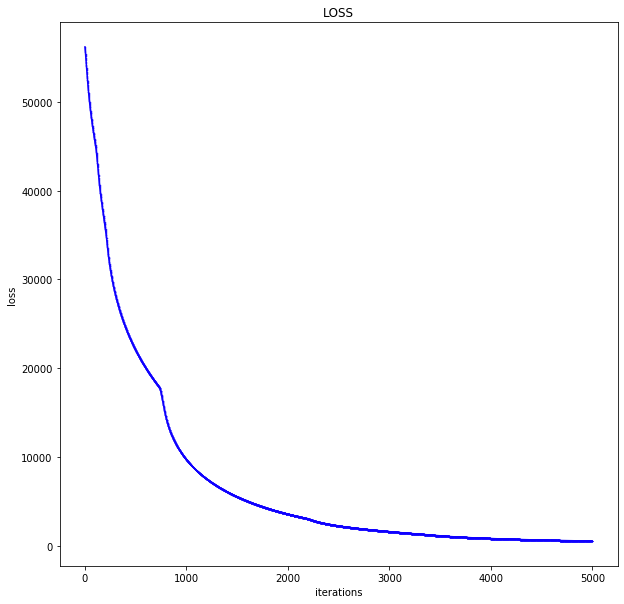

In [11]:
loss = kmeans.history['loss']

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('LOSS')
ax.set_xlabel('iterations')
ax.set_ylabel('loss')
ax.plot(loss, marker='.', color='#0F00FF', markersize=1, linestyle='-')

In [12]:
compressed_img = np.floor(np.clip(kmeans.centroids(X), a_min=0.0, a_max=255.0)).astype('uint8').reshape((600,800,3))

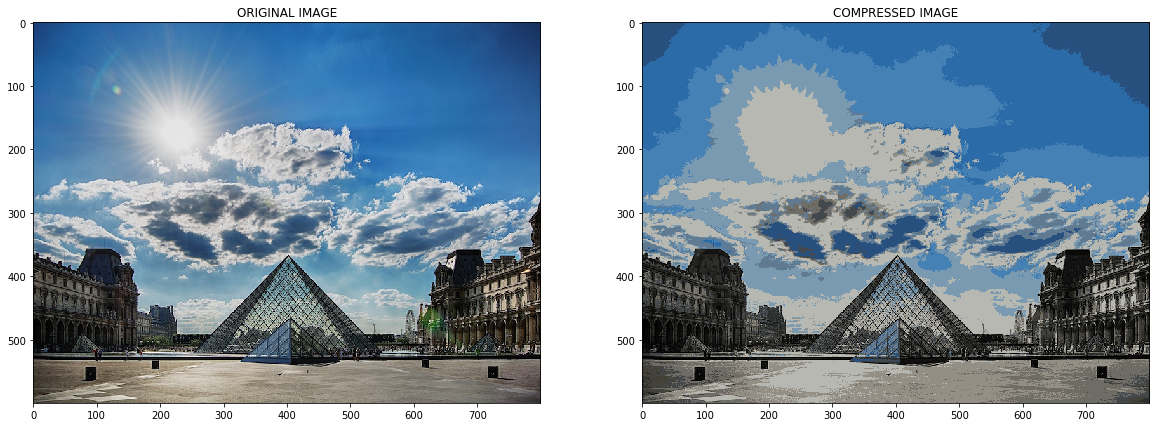

In [13]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('ORIGINAL IMAGE')
ax1.imshow(original_img)
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('COMPRESSED IMAGE')
ax2.imshow(compressed_img)

In [14]:
Image.fromarray(compressed_img).save('compressed_img.png')